Portfolio Risk Simulator

Importing Libraries

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf  

Importing and Extracting Data 

[*********************100%***********************]  7 of 7 completed


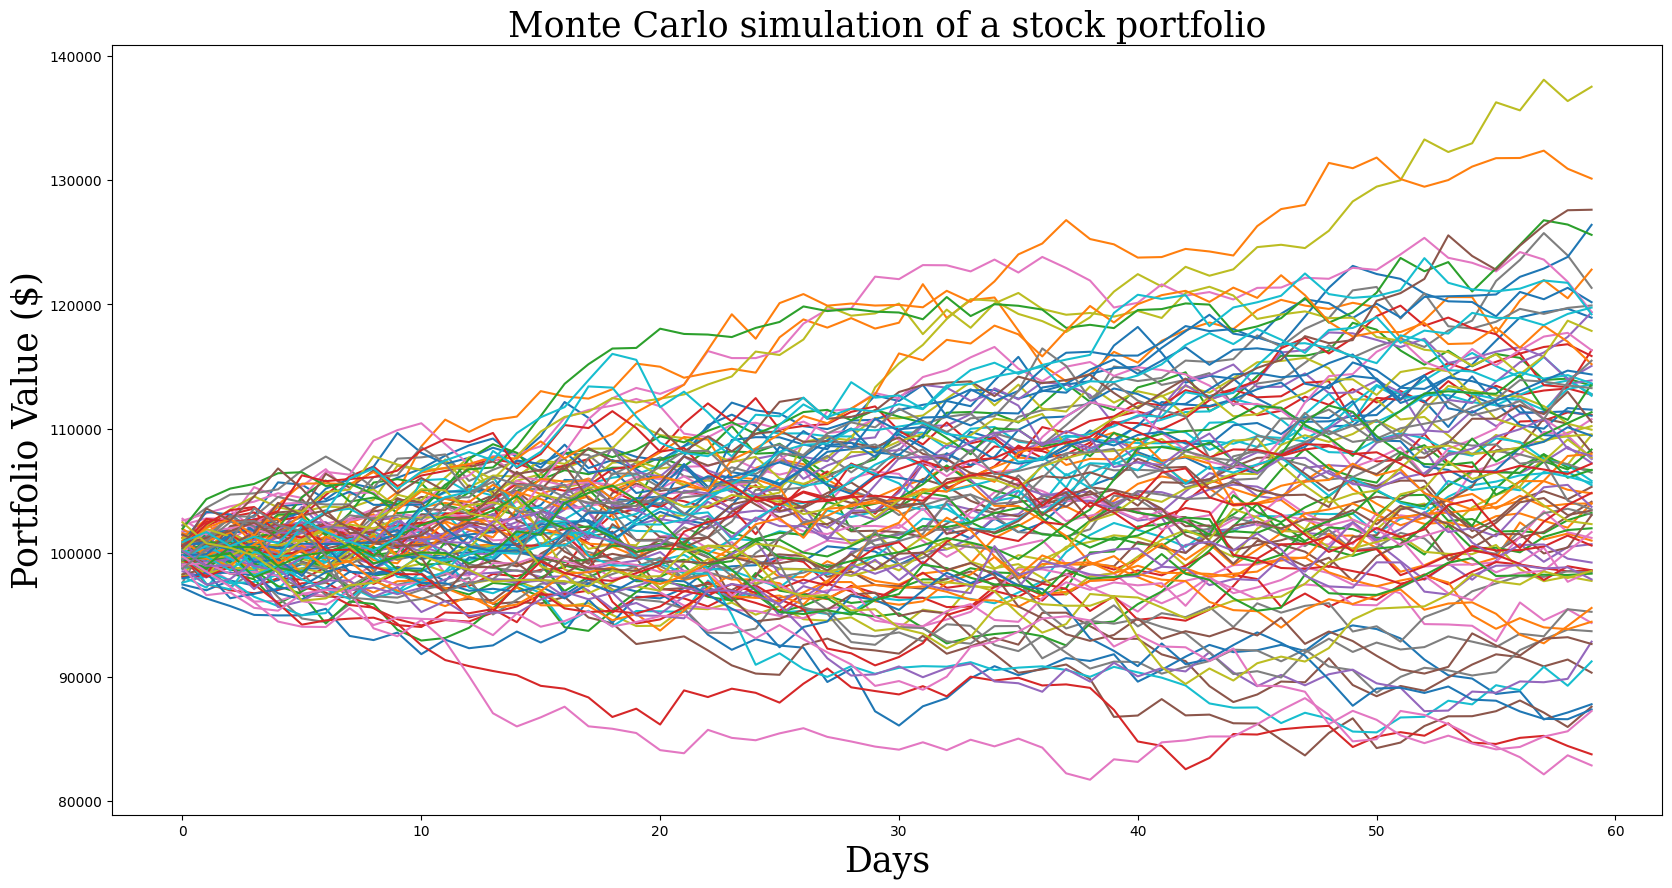

In [ ]:
def getting_data(stocks, start, end):
    # Retry for failed downloads
    stockData = yf.download(stocks, start=start, end=end, threads=True)
    
    # Drop any stocks that cant be downloaded
    stockData = stockData['Close'].dropna(axis=1, how='all')
    
    # Percentage change without filling NaN values
    returns = stockData.pct_change(fill_method=None)
    meanReturns = returns.mean()
    covarianceMatrix = returns.cov()
    return meanReturns, covarianceMatrix

stockList = ['MSFT', 'NVDA', 'V', 'AAPL', 'AB', 'CRM', 'MU' ]
stocks = [stock for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=300)

meanReturns, covarianceMatrix = getting_data(stocks, startDate, endDate)

# Monte Carlo Simulation
weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

mc_sims = 100  # Number of simulations
Tf = 60  # Time frame

meanM = np.full(shape=(Tf, len(weights)), fill_value=meanReturns).T  # Transpose

portfolio_sims = np.full(shape=(Tf, mc_sims), fill_value=0.0)  # Simulation results
initialPortfolio = 100000

for m in range(mc_sims):
    Z = np.random.normal(size=(Tf, len(weights)))  # Random variables
    L = np.linalg.cholesky(covarianceMatrix) 
    dailyReturns = meanM + np.inner(L, Z)  # Correlated daily returns
    portfolio_sims[:, m] = np.cumprod(np.inner(weights, dailyReturns.T) + 1) * initialPortfolio

# Plotting
font = {'family': 'serif',
        'color': 'black',  # Changed font color for better visibility
        'weight': 'normal',
        'size': 25,
        }

plt.figure(figsize=(20, 10))
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)', fontdict=font)
plt.xlabel('Days', fontdict=font)
plt.title('Monte Carlo simulation of a stock portfolio', fontdict=font)
plt.show()

CVAR and VAR Calculations

In [3]:
def mcVAR(returns, alpha):
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expecting a Pandas Data Series")

def mcCVAR(returns, alpha):
    if isinstance(returns, pd.Series):
        belowVAR = returns <= mcVAR(returns, alpha)
        return returns[belowVAR].mean()
    else:
        raise TypeError("Expecting a Pandas Data Series")
    
    
    
        

Results of CVAR and VAR

In [4]:
portResults = pd.Series(portfolio_sims[-1,:])
VaR = initialPortfolio - mcVAR(portResults, 5)
CVaR = initialPortfolio- mcCVAR(portResults, 5)

print('VaR ${:,.2f}'.format(VaR,2))
print('CVaR ${:,.2f}'.format(CVaR,2))

VaR $12,193.75
CVaR $14,208.62
